In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime


In [6]:
from xbbg import blp


## Downloading Data for 3 Maturities

In [2]:
def download_option_data(tickers, expiration_dates):
    
    # empty array to store all the downloaded options
    all_options = []

    # get today's date for time to maturity calculation
    today = datetime.today()
    # getting the interest rate through the closing price of 13 Week Treasury Bill
    fed_funds = yf.Ticker("^IRX").history(period="1d")['Close'].iloc[-1]  

    # iterating through the list of provided tickers
    for ticker in tickers:
        try:
            # fetch most recent 15-minute interval closing price fro spot price
            spot_price = yf.Ticker(ticker).history(period="1d", interval="5m")["Close"].iloc[-1]
        except Exception as e:
            # error handling for the spot price fetching
            print(f"Error fetching 5-min close price for {ticker}: {e}")
            spot_price = None  # Assign None if price fetch fails

        # for each expirations dates getting the option data
        for exp_date in expiration_dates:
            try:
                # convert expiration date to datetime datatype
                exp_datetime = datetime.strptime(exp_date, "%Y-%m-%d")
                time_to_maturity = (exp_datetime - today).days / 365.0  # Convert to years

                # option chain from yfinance
                option_chain = yf.Ticker(ticker).option_chain(exp_date)
                # sperating the calls and puts chains
                calls = option_chain.calls
                puts = option_chain.puts

                # add identifying columns
                calls["ticker"] = ticker
                calls["expiration"] = exp_date
                calls["optionType"] = "Call"
                calls["timeToMaturity"] = round(time_to_maturity, 6)
                calls["spotPrice"] = round(spot_price,6)

                puts["ticker"] = ticker
                puts["expiration"] = exp_date
                puts["optionType"] = "Put"
                puts["timeToMaturity"] = round(time_to_maturity, 6)
                puts["spotPrice"] = round(spot_price,6)

                # combine calls & puts
                all_options.append(calls)
                all_options.append(puts)

            except Exception as e:
                print(f"Error fetching options for {ticker} ({exp_date}): {e}")

    # combine all data into a single DataFrame
    if not all_options:
        return None

    options_data = pd.concat(all_options, ignore_index=True)
    # adding interest rate to all the option data
    options_data["interestRate"] = round(fed_funds, 6)

    # rearrange columns and only getting the necessary fields
    desired_columns = ["ticker", "expiration", "timeToMaturity", "strike", "optionType",
                       "lastPrice", "bid", "ask", "impliedVolatility", "inTheMoney", "spotPrice", "interestRate"]
    options_data = options_data[desired_columns]

    return options_data

In [3]:
# get option data for NVDA fro three different maturities
tickers = ["NVDA"]
expiration_dates = ["2025-03-21", "2025-04-17", "2025-05-16"]
options_data = download_option_data(tickers, expiration_dates)

In [4]:
options_data.head()

,ticker,expiration,timeToMaturity,strike,optionType,lastPrice,bid,ask,impliedVolatility,inTheMoney,spotPrice,interestRate
0,NVDA,2025-03-21,0.016438,5.0,Call,115.00,115.60,116.10,9.187504,True,120.742897,4.188
1,NVDA,2025-03-21,0.016438,10.0,Call,98.92,110.60,111.10,7.031251,True,120.742897,4.188
2,NVDA,2025-03-21,0.016438,15.0,Call,91.75,105.75,106.20,6.570314,True,120.742897,4.188
3,NVDA,2025-03-21,0.016438,20.0,Call,100.80,100.75,101.20,5.648440,True,120.742897,4.188
4,NVDA,2025-03-21,0.016438,25.0,Call,95.37,95.70,96.15,4.765629,True,120.742897,4.188


In [5]:
options_data.to_csv("NVDA_options_data.csv")

In [8]:
import requests

session = requests.Session()

In [10]:
def download_option_data_xbbg(ticker):
    """Fetches option data for the first 3 expiration dates using xbbg (Bloomberg)."""

    # Step 1: Retrieve the first 3 expiration dates
    expiration_dates = blp.bdp(f"{ticker} Equity", "OPT_EXPIRE_DT_LIST")["OPT_EXPIRE_DT_LIST"]
    
    if expiration_dates is None or len(expiration_dates) == 0:
        print(f"No expiration dates found for {ticker}.")
        return None

    expiration_dates = sorted(expiration_dates)[:3]  # Select first 3 expirations

    # Step 2: Fetch spot price
    spot_price = blp.bdp(f"{ticker} Equity", "PX_LAST")["PX_LAST"].iloc[0]

    # Step 3: Fetch options for each expiration date
    all_options = []
    today = datetime.today()

    for exp_date in expiration_dates:
        exp_str = exp_date.strftime("%Y-%m-%d")  # Convert to string format
        time_to_maturity = (exp_date - today).days / 365.0  # Convert to years

        # Fetch all options for this expiration
        option_chain = blp.bds(f"{ticker} Equity", "OPT_CHAIN")
        
        if option_chain is None or option_chain.empty:
            print(f"No option data for {ticker} ({exp_str})")
            continue

        # Process calls and puts
        for idx, row in option_chain.iterrows():
            option_type = "Call" if row["Put Call"] == "Call" else "Put"
            option_data = {
                "ticker": ticker,
                "expiration": exp_str,
                "timeToMaturity": round(time_to_maturity, 6),
                "strike": row["Strike"],
                "optionType": option_type,
                "lastPrice": row["Last Price"],
                "bid": row["Bid"],
                "ask": row["Ask"],
                "impliedVolatility": row["Implied Volatility"],
                "inTheMoney": row["In The Money"],
                "spotPrice": round(spot_price, 6),
            }
            all_options.append(option_data)

    # Combine all data into a DataFrame
    if not all_options:
        return None

    options_data = pd.DataFrame(all_options)

    # Select relevant columns
    desired_columns = ["ticker", "expiration", "timeToMaturity", "strike", "optionType",
                       "lastPrice", "bid", "ask", "impliedVolatility", "inTheMoney", "spotPrice"]
    options_data = options_data[desired_columns]

    return options_data

In [ ]:


ticker = "NVDA"
option_data = download_option_data_xbbg(ticker)
print(option_data)


## Visualize Results

In [3]:
df = pd.read_csv('NVDA_options_data.csv')
NVDA_spot = df.iloc[1, -2]

NVDA_spot

139.360596

In [4]:
NVDA_output_df = pd.read_csv('output_NVDA_test.csv')
NVDA_output_df.head()

,Ticker,Expiration,TimeToMaturity,Strike,OptionType,LastPrice,Bid,Ask,ImpliedVolatility,BisectionIV,BisectionTime,Bs_price,Binom_price,American_binom_price,InTheMoney
0,NVDA,2025-03-21,0.076712,5,Call,134.70,134.35,135.10,6.06250,0.00010,0.010880,134.377,134.377,134.377,True
1,NVDA,2025-03-21,0.076712,10,Call,124.00,129.35,130.15,4.67188,0.00010,0.000603,129.393,129.393,129.393,True
2,NVDA,2025-03-21,0.076712,15,Call,104.65,124.30,125.05,3.76953,0.00010,0.000674,124.409,124.409,124.409,True
3,NVDA,2025-03-21,0.076712,20,Call,120.03,119.35,120.10,3.33985,0.00010,0.000379,119.425,119.425,119.425,True
4,NVDA,2025-03-21,0.076712,25,Call,106.22,114.35,115.10,2.95313,2.94676,0.002919,114.725,114.730,114.730,True


In [43]:
filtered_df = NVDA_output_df[
    (NVDA_spot / NVDA_output_df['Strike'] >= 0.9) &
    (NVDA_spot / NVDA_output_df['Strike'] <= 1.1) &
    (NVDA_output_df['Strike']%5 == 0)
]

In [44]:
filtered_df = filtered_df[['Expiration','Strike', 'OptionType', 'Ask', 'Bid', 'Bs_price', 'Binom_price', 'American_binom_price']]


In [45]:
filtered_df

,Expiration,Strike,OptionType,Ask,Bid,Bs_price,Binom_price,American_binom_price
78,2025-03-21,130,Call,15.05,14.95,15.00000,15.00150,15.00150
81,2025-03-21,135,Call,11.90,11.80,11.85000,11.84840,11.84840
86,2025-03-21,140,Call,9.20,9.15,9.17498,9.17722,9.17722
91,2025-03-21,145,Call,7.00,6.90,6.95000,6.95048,6.95048
96,2025-03-21,150,Call,5.15,5.05,5.10000,5.10032,5.10032
401,2025-03-21,130,Put,4.80,4.75,4.77500,4.77639,4.78854
404,2025-03-21,135,Put,6.65,6.60,6.62500,6.62454,6.64347
409,2025-03-21,140,Put,8.95,8.90,8.92500,8.92717,8.95577
414,2025-03-21,145,Put,11.75,11.65,11.70000,11.69780,11.74010
419,2025-03-21,150,Put,14.95,14.85,14.90000,14.90180,14.96180


In [3]:
import matplotlib.pyplot as plt

## PLotting Implied Vol from BS, BT, and TT

In [4]:
#load all the datasets for Data 1
nvda_data1_df = pd.read_csv("NVDA_outputData1.csv")
spy_data1_df = pd.read_csv("SPY_outputData1.csv")
vix_data1_df = pd.read_csv("^VIX_outputData1.csv")

In [5]:
#get spot price for data 1
# using the downlaoded data for the spot price
df= pd.read_csv("options_data1.csv")
nvda_data1_spot = df.query('ticker == "NVDA"').iloc[1,-2]
spy_data1_spot = df.query('ticker == "SPY"').iloc[1,-2]

In [15]:
nvda_data1_df.columns

Index(['Ticker', 'Expiration', 'TimeToMaturity', 'Strike', 'OptionType',
       'LastPrice', 'Bid', 'Ask', 'ImpliedVolatility', 'BisectionIV',
       'BisectionTime', 'Bs_price', 'Binom_price', 'American_binom_price',
       'Binom_bisection_iv', ' Trinom_bisection_iv', 'InTheMoney'],
      dtype='object')

In [16]:
# Ensure Expiration is in datetime format
nvda_data1_df["Expiration"] = pd.to_datetime(nvda_data1_df["Expiration"])
spy_data1_df["Expiration"] = pd.to_datetime(spy_data1_df["Expiration"])
vix_data1_df["Expiration"] = pd.to_datetime(vix_data1_df['Expiration'])

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "Binom_bisection_iv", " Trinom_bisection_iv", "ImpliedVolatility"]

# Function to get ATM IV for each expiration
def get_atm_row(df, spot_price):
    if df.empty:
        return None  # Return None if no matching expiration
    
    # Find ATM strike (closest to spot price)
    closest_strike = df.iloc[(df["Strike"] - spot_price).abs().argmin()]["Strike"]
    
    # Filter the row that matches the closest strike
    atm_row = df[df["Strike"] == closest_strike]
    
    
    return atm_row

# Apply the function to groupby object for each expiration
nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data1_spot).reset_index(drop=True)
spy_atm_iv = spy_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=spy_data1_spot).reset_index(drop=True)

# Combine both NVDA and SPY data into a single table
atm_iv_table = pd.concat([nvda_atm_iv, spy_atm_iv], ignore_index=True)
atm_iv_table = atm_iv_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_49460/2893515549.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atm_iv = nvda_data1_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data1_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_49460/2893515549.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atm_iv = spy_data1_df.groupb

In [17]:
atm_iv_table

,Ticker,Expiration,OptionType,Strike,BisectionIV,Binom_bisection_iv,Trinom_bisection_iv,ImpliedVolatility
0,NVDA,2025-02-21,Call,132.0,0.458217,0.457951,0.458099,0.419684
1,NVDA,2025-02-21,Put,132.0,0.511800,0.511573,0.000100,0.453130
2,NVDA,2025-03-21,Call,132.0,0.586375,0.586627,0.586703,0.585942
3,NVDA,2025-03-21,Put,132.0,0.611904,0.612188,0.612262,0.578007
4,NVDA,2025-04-17,Call,130.0,0.532450,0.531819,0.532119,0.545293
5,NVDA,2025-04-17,Put,130.0,0.548353,0.547717,0.548016,0.517461
6,SPY,2025-02-21,Call,604.0,0.107713,0.107630,0.107671,0.103250
7,SPY,2025-02-21,Put,604.0,0.152178,0.152127,0.152167,0.129647
8,SPY,2025-03-21,Call,604.0,0.120918,0.120943,0.000100,0.134149
9,SPY,2025-03-21,Put,604.0,0.148769,0.148826,0.148846,0.129083


In [19]:
# Define a function to compute the average IV for a given DataFrame
def compute_average_iv(df, ticker):
    avg_iv_table = (
        df.groupby(["Expiration", "OptionType", "InTheMoney"])[["BisectionIV","Binom_bisection_iv"," Trinom_bisection_iv", "ImpliedVolatility"]]
        .mean()
        .reset_index()
    )
    avg_iv_table["Ticker"] = ticker  # Add a column to distinguish NVDA vs SPY
    return avg_iv_table

# Compute average IV tables for NVDA and SPY
nvda_average_iv_table = compute_average_iv(nvda_data1_df, "NVDA")
spy_average_iv_table = compute_average_iv(spy_data1_df, "SPY")

# Concatenate the tables
combined_average_iv_table = pd.concat([nvda_average_iv_table, spy_average_iv_table], ignore_index=True)

# Reorder columns to match the ATM IV table format
desired_columns = ["Ticker", "Expiration", "OptionType", "InTheMoney", "BisectionIV","Binom_bisection_iv"," Trinom_bisection_iv", "ImpliedVolatility"]
combined_average_iv_table = combined_average_iv_table[desired_columns]

In [20]:
combined_average_iv_table

,Ticker,Expiration,OptionType,InTheMoney,BisectionIV,Binom_bisection_iv,Trinom_bisection_iv,ImpliedVolatility
0,NVDA,2025-02-21,Call,False,0.275367,0.275454,0.274769,4.213820
1,NVDA,2025-02-21,Call,True,0.047756,0.047767,0.047884,0.219976
2,NVDA,2025-02-21,Put,False,1.123846,1.126790,1.123786,1.788257
3,NVDA,2025-02-21,Put,True,0.295309,0.295526,0.166178,0.475116
4,NVDA,2025-03-21,Call,False,0.249491,0.249757,0.249496,2.737434
5,NVDA,2025-03-21,Call,True,0.180797,0.180834,0.218941,1.006442
6,NVDA,2025-03-21,Put,False,0.954504,0.956427,0.954502,0.942719
7,NVDA,2025-03-21,Put,True,0.409862,0.409825,0.410097,0.369171
8,NVDA,2025-04-17,Call,False,0.575801,0.576443,0.575862,0.576083
9,NVDA,2025-04-17,Call,True,0.247414,0.247486,0.247750,1.064953


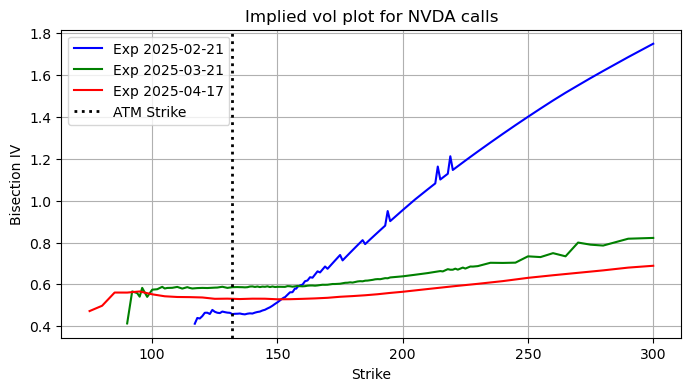

In [22]:
expirations = nvda_data1_df['Expiration'].unique()

# Filter Calls first
nvda_call_df = nvda_data1_df.loc[nvda_data1_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
nvda_call_df1 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[0]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df2 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[1]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df3 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[2]) & (nvda_call_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_call_df1["Strike"], nvda_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_call_df2["Strike"], nvda_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_call_df3["Strike"], nvda_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for NVDA calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()


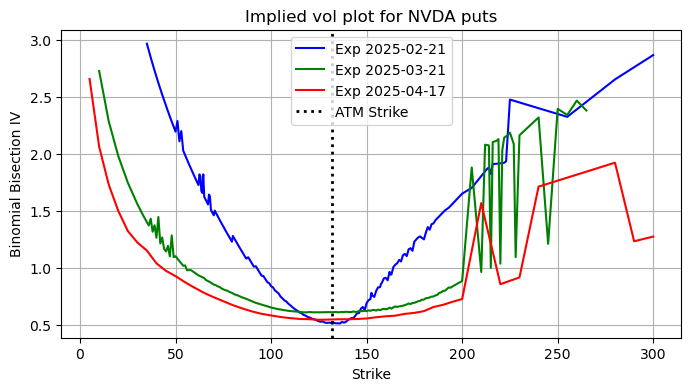

In [23]:
# Filter Calls first
nvda_call_df = nvda_data1_df.loc[nvda_data1_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
nvda_call_df1 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[0]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df2 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[1]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df3 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[2]) & (nvda_call_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_call_df1["Strike"], nvda_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_call_df2["Strike"], nvda_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_call_df3["Strike"], nvda_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for NVDA puts")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

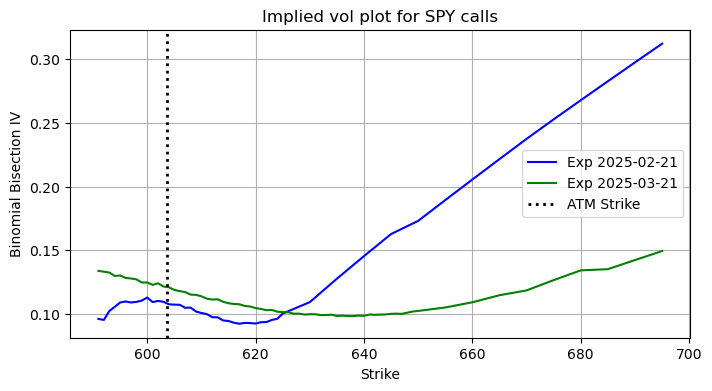

In [27]:
# Filter Calls first
spy_call_df = spy_data1_df.loc[spy_data1_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
spy_call_df1 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[0]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df2 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[1]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df3 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[2]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700) & (spy_call_df["BisectionIV"]) < 1.2]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(spy_call_df1["Strike"], spy_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(spy_call_df2["Strike"], spy_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
#plt.plot(spy_call_df3["Strike"], spy_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=spy_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for SPY calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

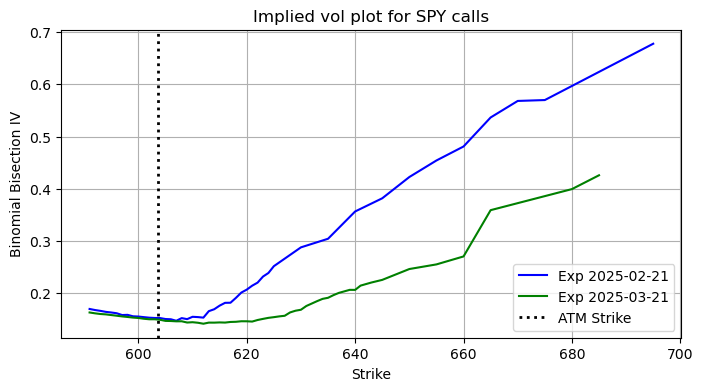

In [29]:
# Filter puts first
spy_call_df = spy_data1_df.loc[spy_data1_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
spy_call_df1 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[0]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df2 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[1]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df3 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[2]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700) & (spy_call_df["BisectionIV"]) < 1.2]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(spy_call_df1["Strike"], spy_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(spy_call_df2["Strike"], spy_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
#plt.plot(spy_call_df3["Strike"], spy_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=spy_data1_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for SPY calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

### Data 2

In [ ]:
#load all the datasets for Data 2
nvda_data2_df = pd.read_csv("NVDA_outputData2.csv")
spy_data2_df = pd.read_csv("SPY_outputData2.csv")
vix_data2_df = pd.read_csv("^VIX_outputData2.csv")

In [31]:
#get spot price for data 2
# using the downlaoded data for the spot price
df= pd.read_csv("options_data2.csv")
nvda_data2_spot = df.query('ticker == "NVDA"').iloc[1,-2]
spy_data2_spot = df.query('ticker == "SPY"').iloc[1,-2]

In [32]:
# Ensure Expiration is in datetime format
nvda_data2_df["Expiration"] = pd.to_datetime(nvda_data2_df["Expiration"])
spy_data2_df["Expiration"] = pd.to_datetime(spy_data2_df["Expiration"])
vix_data2_df["Expiration"] = pd.to_datetime(vix_data2_df['Expiration'])

desired_columns = ["Ticker", "Expiration", "OptionType", "Strike", "BisectionIV", "Binom_bisection_iv", " Trinom_bisection_iv", "ImpliedVolatility"]

# Apply the function to groupby object for each expiration
nvda_atm_iv = nvda_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data2_spot).reset_index(drop=True)
spy_atm_iv = spy_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=spy_data2_spot).reset_index(drop=True)

# Combine both NVDA and SPY data into a single table
atm_iv_table = pd.concat([nvda_atm_iv, spy_atm_iv], ignore_index=True)
atm_iv_table = atm_iv_table[desired_columns]

/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_49460/1611389857.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nvda_atm_iv = nvda_data2_df.groupby("Expiration").apply(get_atm_row, spot_price=nvda_data2_spot).reset_index(drop=True)
/var/folders/mb/ht8b7n2j03ddmrts10cdkdy00000gn/T/ipykernel_49460/1611389857.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spy_atm_iv = spy_data2_df.groupby

In [33]:
atm_iv_table

,Ticker,Expiration,OptionType,Strike,BisectionIV,Binom_bisection_iv,Trinom_bisection_iv,ImpliedVolatility
0,NVDA,2025-02-21,Call,135.0,0.519627,0.519630,0.519732,0.467290
1,NVDA,2025-02-21,Put,135.0,0.399964,0.399851,0.399952,0.349128
2,NVDA,2025-03-21,Call,135.0,0.624907,0.625361,0.625415,0.622562
3,NVDA,2025-03-21,Put,135.0,0.568701,0.569091,0.569140,0.536137
4,NVDA,2025-04-17,Call,135.0,0.556155,0.556600,0.556643,0.567021
5,NVDA,2025-04-17,Put,135.0,0.515747,0.516147,0.516185,0.486822
6,SPY,2025-02-21,Call,606.0,0.142894,0.143039,0.000100,0.132760
7,SPY,2025-02-21,Put,606.0,0.110874,0.110980,0.000100,0.091684
8,SPY,2025-03-21,Call,606.0,0.136315,0.136470,0.000100,0.148995
9,SPY,2025-03-21,Put,606.0,0.129498,0.129645,0.000100,0.110605


In [34]:
# Compute average IV tables for NVDA and SPY
nvda_average_iv_table = compute_average_iv(nvda_data2_df, "NVDA")
spy_average_iv_table = compute_average_iv(spy_data2_df, "SPY")

# Concatenate the tables
combined_average_iv_table = pd.concat([nvda_average_iv_table, spy_average_iv_table], ignore_index=True)

# Reorder columns to match the ATM IV table format
desired_columns = ["Ticker", "Expiration", "OptionType", "InTheMoney", "BisectionIV","Binom_bisection_iv"," Trinom_bisection_iv", "ImpliedVolatility"]
combined_average_iv_table = combined_average_iv_table[desired_columns]

In [35]:
combined_average_iv_table

,Ticker,Expiration,OptionType,InTheMoney,BisectionIV,Binom_bisection_iv,Trinom_bisection_iv,ImpliedVolatility
0,NVDA,2025-02-21,Call,False,0.275833,0.276565,0.275806,4.487290
1,NVDA,2025-02-21,Call,True,0.907741,0.907984,1.428624,3.553742
2,NVDA,2025-02-21,Put,False,1.104510,1.107508,1.104467,1.852996
3,NVDA,2025-02-21,Put,True,0.049619,0.049666,0.049654,0.310280
4,NVDA,2025-03-21,Call,False,0.249243,0.249461,0.249239,2.802901
5,NVDA,2025-03-21,Call,True,1.207623,1.206306,0.259351,1.533693
6,NVDA,2025-03-21,Put,False,0.954706,0.956660,0.954643,0.937430
7,NVDA,2025-03-21,Put,True,0.360079,0.360141,0.360307,0.297552
8,NVDA,2025-04-17,Call,False,0.581875,0.582486,0.581771,0.582285
9,NVDA,2025-04-17,Call,True,1.052540,1.163727,1.398731,1.550193


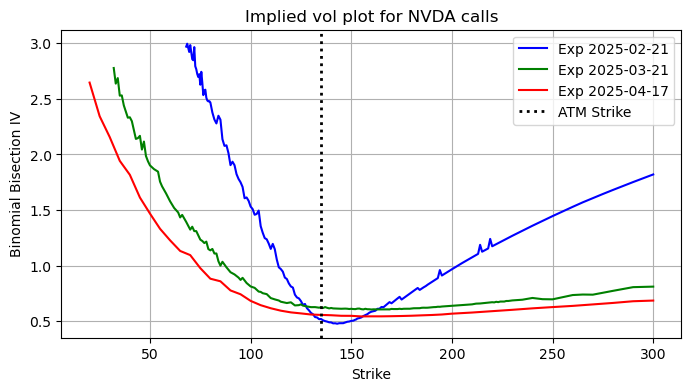

In [36]:
expirations = nvda_data2_df['Expiration'].unique()

# Filter Calls first
nvda_call_df = nvda_data2_df.loc[nvda_data2_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
nvda_call_df1 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[0]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df2 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[1]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df3 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[2]) & (nvda_call_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_call_df1["Strike"], nvda_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_call_df2["Strike"], nvda_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_call_df3["Strike"], nvda_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data2_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for NVDA calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

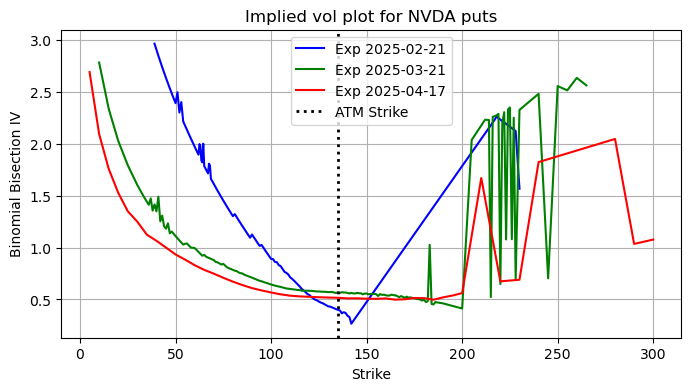

In [37]:
# Filter Puts first
nvda_call_df = nvda_data2_df.loc[nvda_data2_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
nvda_call_df1 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[0]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df2 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[1]) & (nvda_call_df["BisectionIV"] > 0.0001)]
nvda_call_df3 = nvda_call_df.loc[(nvda_call_df["Expiration"] == expirations[2]) & (nvda_call_df["BisectionIV"] > 0.0001)]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(nvda_call_df1["Strike"], nvda_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(nvda_call_df2["Strike"], nvda_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
plt.plot(nvda_call_df3["Strike"], nvda_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=nvda_data2_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for NVDA puts")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

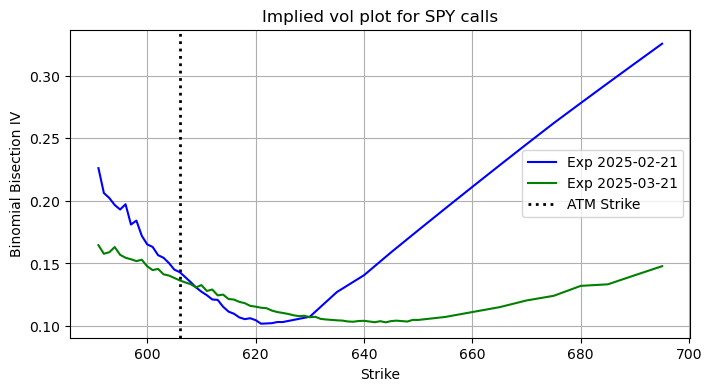

In [40]:
# Filter Calls first
spy_call_df = spy_data2_df.loc[spy_data2_df["OptionType"] == "Call"]

# Filter for each expiration & valid BisectionIV values
spy_call_df1 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[0]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df2 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[1]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df3 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[2]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700) & (spy_call_df["BisectionIV"]) < 1.2]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(spy_call_df1["Strike"], spy_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(spy_call_df2["Strike"], spy_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
#plt.plot(spy_call_df3["Strike"], spy_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=spy_data2_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for SPY calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()

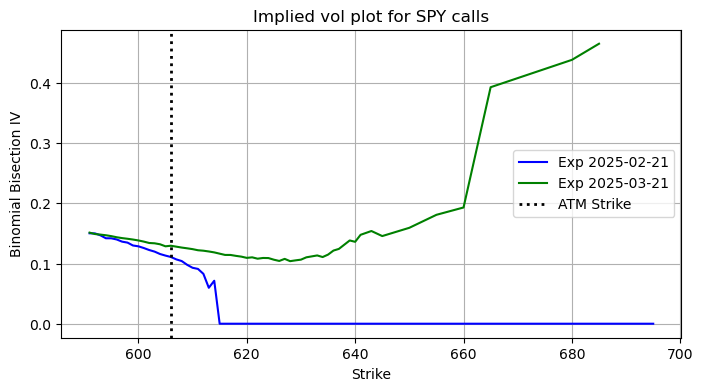

In [41]:
# Filter puts first
spy_call_df = spy_data2_df.loc[spy_data2_df["OptionType"] == "Put"]

# Filter for each expiration & valid BisectionIV values
spy_call_df1 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[0]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df2 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[1]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700)]
spy_call_df3 = spy_call_df.loc[(spy_call_df["Expiration"] == expirations[2]) & (spy_call_df["Strike"] > 590) & (spy_call_df["Strike"] < 700) & (spy_call_df["BisectionIV"]) < 1.2]

# Plot
plt.figure(figsize=(8, 4))

plt.plot(spy_call_df1["Strike"], spy_call_df1["Binom_bisection_iv"], label=f"Exp {expirations[0].date()}", color="blue")
plt.plot(spy_call_df2["Strike"], spy_call_df2["Binom_bisection_iv"], label=f"Exp {expirations[1].date()}", color="green")
#plt.plot(spy_call_df3["Strike"], spy_call_df3["Binom_bisection_iv"], label=f"Exp {expirations[2].date()}", color="red")

# Add a vertical dotted line at ATM Strike
plt.axvline(x=spy_data2_spot, color='black', linestyle='dotted', linewidth=2, label="ATM Strike")

# Labels and Title
plt.xlabel("Strike")
plt.ylabel("Binomial Bisection IV")
plt.title("Implied vol plot for SPY calls")
plt.grid(True)  # Add grid lines
plt.legend()  # Show legend

# Show the plot
plt.show()